**Brian Blaylock**  
**June 10, 2019**

# _Not Shown_: Frequency bias timeseries 

Ratio of grid points that are forecasted lightning and observed lighting.

$$\frac{Total Forecasted Grid Cells}{Total Observed Grid Cells} = \frac{(A+B)}{(A+C)}$$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import itertools

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3')
from BB_wx_calcs.binary_events import hit_rate, false_alarm_ratio, base_rate, frequency_bias

In [90]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [6,9]
mpl.rcParams['figure.titlesize'] = 10
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 7
mpl.rcParams['ytick.labelsize'] = 7
mpl.rcParams['axes.labelsize'] = 7
mpl.rcParams['axes.titlesize'] = 8
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['grid.alpha'] = .5
#mpl.rcParams['figure.subplot.wspace'] = 0.15
#mpl.rcParams['figure.subplot.hspace'] = 0.15

mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['legend.framealpha'] = .95
mpl.rcParams['legend.labelspacing'] = 0.1
mpl.rcParams['legend.handlelength'] = 1
mpl.rcParams['legend.handletextpad'] = 0.5
mpl.rcParams['legend.borderaxespad'] = 0.3
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.columnspacing'] = 1.0

mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 600

In [5]:
def get_contingency_table_by_hour(HOUR, MONTHS=range(5,11)):
    """
    Return a dictionary of all the data for the specified Hour from each month.
    
    Input:
        HOUR   - The hour of day, 0-23.
        MONTHS - Default is May-Oct, becuase that is what is avaialble right now.
    """
    data_dict = {}
    for DOMAIN in domains:
        data_dict[DOMAIN] = {}
        for MONTH in MONTHS:
            DIR = '/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_HRRR/GLM_and_HRRR/HRRR_GLM_contingency_table'
            FILE = '/%s/%s_2018_m%02d_h%02d.csv' % (DOMAIN, DOMAIN, MONTH, HOUR)
            data_dict[DOMAIN][MONTH] = np.genfromtxt(DIR+FILE, delimiter=',', names=True, dtype=None, encoding='UTF-8')    
    return data_dict

def get_FSS_by_hour(HOUR, radius, MONTHS=range(5,11)):
    """
    Return a dictionary of all the data for the specified Hour from each month.
    
    Input:
        HOUR   - The hour of day, 0-23.
        MONTHS - Default is May-Oct, becuase that is what is avaialble right now.
    """
    data_dict = {}
    for DOMAIN in domains:
        data_dict[DOMAIN] = {}
        for MONTH in MONTHS:
            try:
                DIR = '/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_HRRR/GLM_and_HRRR/HRRR_GLM_Fractions_Skill_Score_r%02d/' % radius
                FILE = '%s/%s_2018_m%02d_h%02d.csv' % (DOMAIN, DOMAIN, MONTH, HOUR)
                data_dict[DOMAIN][MONTH] = np.genfromtxt(DIR+FILE, delimiter=',', names=True, dtype=None, encoding='UTF-8')    
            except:
                data_dict[DOMAIN][MONTH] = np.ones_like(range(18))*np.nan
    return data_dict

In [25]:
def get_bias_ts(DOMAIN, fxx=6):
    BIAS_ts = []    
    dates = []
    for m in MONTHS:
        dates = list(dates) + list(Table_all[DOMAIN][m]['DATE'])
        A = np.array(Table_all[DOMAIN][m]['F%02d_A' % fxx])
        B = np.array(Table_all[DOMAIN][m]['F%02d_B' % fxx])
        C = np.array(Table_all[DOMAIN][m]['F%02d_C' % fxx])
        D = np.array(Table_all[DOMAIN][m]['F%02d_D' % fxx])

        BIAS = frequency_bias(A, B, C, D)
        BIAS_ts = list(BIAS_ts) + list(BIAS)

    # Convert dates string to Datetime object    
    DATES = np.array([])
    for D in dates:
        try:
            DATES = np.append(DATES, datetime.strptime(D, '%Y-%m-%d %H:%M:%S'))
        except:
            DATES = np.append(DATES, datetime.strptime(D, '%m/%d/%Y %H:%M'))

    return BIAS_ts, DATES

In [65]:
def plot_add_HRRR_version_line(ax, text=True):
    ax.axvline(datetime(2018, 7, 12, 12), linestyle='--', color='k', zorder=0)
    if text:
        yloc = 2.75
        ax.text(datetime(2018, 7, 10), yloc, 'HRRRv2', fontsize=7, ha='right')
        ax.text(datetime(2018, 7, 15), yloc, 'HRRRv3', fontsize=7, ha='left')

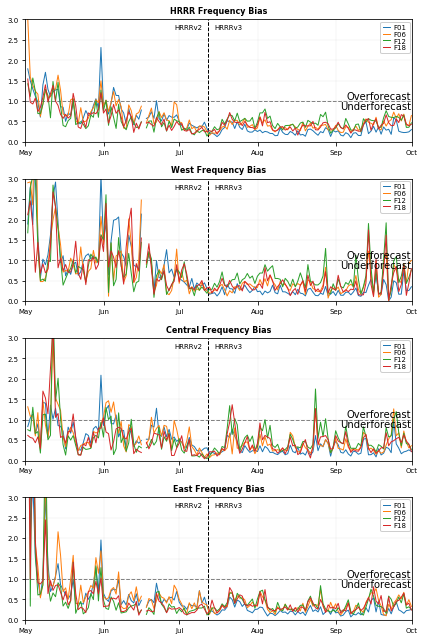

In [93]:
domains = ['HRRR', 'West', 'Central', 'East']
MONTHS = range(5,10)
HOUR = 22

Table_all = get_contingency_table_by_hour(HOUR, MONTHS=MONTHS)

fig, axes = plt.subplots(4,1)

for ax, DOMAIN in zip(axes, domains):
    plt.sca(ax)
    for f in [1, 6, 12, 18]:
    #for f in range(1,19):
        bias, DATES = get_bias_ts(DOMAIN, f)
        plt.plot(DATES, bias, label='F%02d' % f)
    plt.legend()
    
    plt.axhline(1, color='grey', linestyle='--', zorder=0)
    plt.text(DATES[-1], 1, 'Overforecast', ha='right', va='bottom');
    plt.text(DATES[-1], 1, 'Underforecast', ha='right', va='top');
        
    plt.title(DOMAIN+' Frequency Bias', fontweight='bold')
    
    plot_add_HRRR_version_line(ax, text=True)
    
    formatter = DateFormatter('%b')
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(mdates.DayLocator([1]))
    ax.grid(zorder=0)
    
    plt.ylim([0,3])
    plt.xlim([datetime(2018,5,1), datetime(2018, 10,1)])

    plt.tight_layout()
plt.savefig('./figs/not-shown_Bias_TimeSeries_h%02d' % HOUR)